In [126]:
import requests
import os
from datetime import datetime
from pathlib import Path
import pyarrow
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import contextily as cx
import seaborn as sns

def strip_axes(ax):
    """Despine axis and remove ticks and labels."""
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

root_dir = Path("~/Desktop/Desktop/epidemiology_PhD/00_repos/").expanduser()
# root_dir = "/Volumes/squirrel-utopia 1/los_angeles_2025_fire_disasters_exp/"

In [127]:
# Ready to read data
data_dir = root_dir / "los_angeles_2025_fire_disasters_exp/data"

sep_fires_path =  data_dir / "sep_fires.parquet"
kaiser_affected_path = data_dir / "num_kaiser_pop_age_60_affected_la_wf.csv"
zctas_path = data_dir / "zctas_2020.parquet"

fires = gpd.read_parquet(sep_fires_path).to_crs("EPSG:3857")
kaiser_affected = pd.read_csv(kaiser_affected_path)
zctas = gpd.read_parquet(zctas_path).assign(zcta = lambda x: x.zcta.astype(int)).to_crs("EPSG:3857")

In [141]:
kaiser_zctas = zctas.merge(kaiser_affected, on = "zcta", how = "inner").dissolve(by = "zcta", aggfunc = "sum")
kaiser_zctas['ppl_affected_bin'] = pd.cut(kaiser_zctas['ppl_affected'], bins = [0, 10, 25, 100, 250, 500, 1000, 2000], labels = ["0-10", "10-25", "25-100", "100-250", "250-500", "500-1000", "1000-2000"], include_lowest = True, right = False)
kaiser_zctas['zcta_centroid'] = kaiser_zctas.centroid
kaiser_zctas = kaiser_zctas.reset_index()

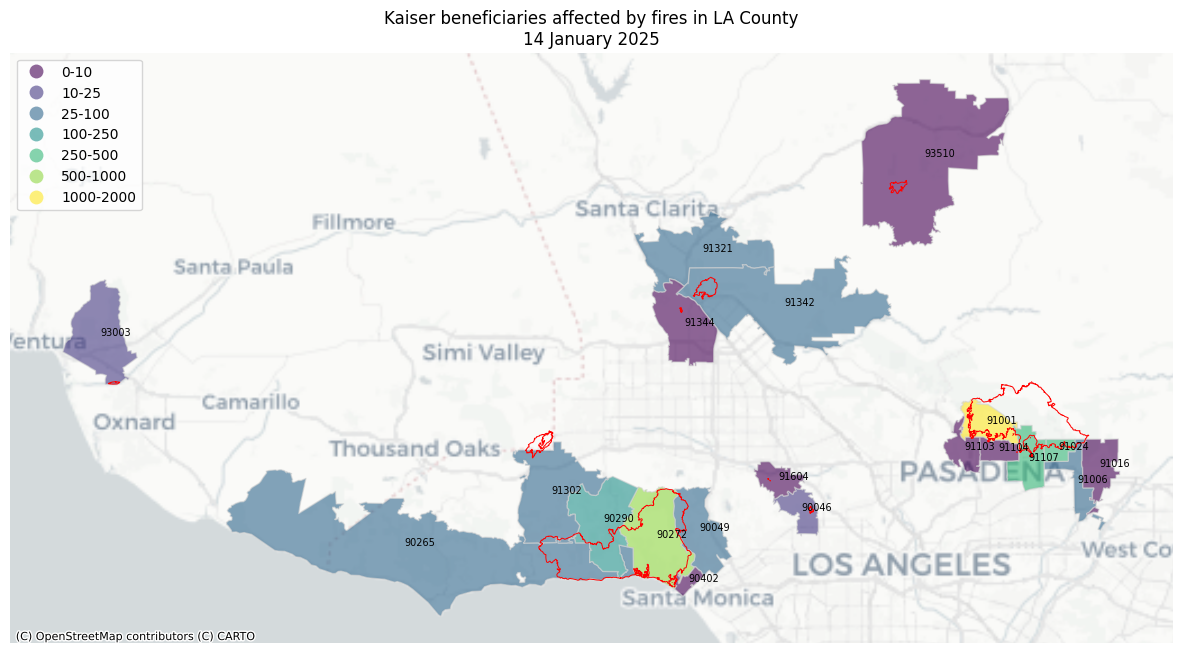

In [142]:
fig, ax = plt.subplots(figsize = (15, 15))
kaiser_zctas.plot("ppl_affected_bin", ax = ax, legend = True, alpha = 0.6, cmap = "viridis", legend_kwds = {"loc": "upper left"}, edgecolor = "lightgrey")
fires.boundary.plot(ax = ax, color = "red", linewidth = .7)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title("Kaiser beneficiaries affected by fires in LA County\n14 January 2025")
item =list(kaiser_zctas.itertuples())[0]
strip_axes(ax)
for idx, row in list(kaiser_zctas.to_crs("EPSG:3857").iterrows()):
    centroid = row["zcta_centroid"]
    ax.text(
        centroid.x,
        centroid.y,
        str(row["zcta"]),
        fontsize = 7
    )